# Flatiron Health mPC: MICE

**OBJECTIVE: Impute missing variables in the training dataset using multiple imputation chained equations (MICE). Five non-missing training sets will be construced using MICE along with 5 test sets. A gradient boosted model will be fit to each training dataset and a test set AUC will be calculated. The 1 year AUCs from the test set will be pooled to get a final estimate.** 

**BACKGROUND: The variables with the most missingness at time of metastatic diagnosis are ECOG (50%), labs (30%), and changes in weight (11%). These three variables have high predictive value in our models. Up until this point, missingness has been handled by making "unknown" a level in the ECOG variable and imputing median for lab values and weight loss. While this imputation strategy is simple and fast, it likely understimates the variance of variables and disturb relations between variables when the data is not missing completely at random.** 

**Variables that will be imputed with MICE:** 
1. **ECOG (48% missing)**
2. **BMI (15% missing)**
3. **Weight (25% missing)**
4. **Percent change in weight and weight slope (11% missing)**
5. **Socioeconomic status (20% missing)**
6. **Stage (40%)**
7. **Labs at time of advanced diagnosis (30% missing)**
8. **Subset of summary labs (40% missing)**

**Five complete training sets will be imputed using the Python package "miceforest" which uses lightgbm as a backend. Five complete test sets will also be imputed from the final model used to impute the training set values. All existing variables including outcome variables like death status and time until event will be utilized to aid in the imputations. In addition, auxillary variables such as receipt of treatment, weight and BMI at 3 months, and labs at 3 months will be created to augment imputations.**   

**After complete training and test sets are constructed, a gradient boosting survival model will be built for each training set in the same fashion as in the crude imputation notebook. Final test AUCs will be pooled using Rubin's rules.**

**OUTLINE:**
1. **Building auxillary variables** 
2. **Performing MICE on training and test sets** 
3. **Building gradient boosting models on imputed datasets**
4. **Pooling results**

## 1. Building auxillary varibles 

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

### 1.1 Preprocessing

In [3]:
train = pd.read_csv('train_full.csv')
row_ID(train)

(15141, 15141)

In [4]:
test = pd.read_csv('test_full.csv')
row_ID(test)

(3786, 3786)

In [5]:
df = pd.concat([train, test], ignore_index = True)
row_ID(df)

(18927, 18927)

### 1.2 Treatment 

**Add indicator variables for receipt of various treatment. The 5 major treatment categories include: ADT, FDA approved therapy for metastatic HSPC that isn't ADT, alpha beta emitters, sipuleucel-T, and an FDA approved therapy for metastatic CRPC.** 

In [6]:
line_therapy = pd.read_csv('LineOfTherapy.csv')
adt = pd.read_csv('Enhanced_MetPC_ADT.csv')
abe = pd.read_csv('Enhanced_MetPC_AlphaBetaEmitters.csv')
sipt = pd.read_csv('Enhanced_MetPC_Provenge.csv')
enhanced_met = pd.read_csv('Enhanced_MetProstate.csv')

In [7]:
line_therapy = line_therapy[line_therapy['PatientID'].isin(df['PatientID'])]

adt = adt[adt['PatientID'].isin(df['PatientID'])]
adt.loc[:, 'StartDate'] = pd.to_datetime(adt['StartDate'])

abe = abe[abe['PatientID'].isin(df['PatientID'])]
abe.loc[:, 'AdministrationDate'] = pd.to_datetime(abe['AdministrationDate'])

sipt = sipt[sipt['PatientID'].isin(df['PatientID'])]
sipt.loc[:, 'StartDate'] = pd.to_datetime(sipt['StartDate'])

enhanced_met = enhanced_met[enhanced_met['PatientID'].isin(df['PatientID'])]
enhanced_met.loc[:, 'MetDiagnosisDate'] = pd.to_datetime(enhanced_met['MetDiagnosisDate'])

In [8]:
adt = pd.merge(adt, enhanced_met[['PatientID', 'MetDiagnosisDate']], on = 'PatientID')

adt = (
    adt
    .assign(adt_diff = (adt['StartDate'] - adt['MetDiagnosisDate']).dt.days)
    .query('adt_diff >= -90')
    .sort_values(by = ['PatientID', 'StartDate'], ascending = [False, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID']]
)

adt.loc[:,'late_adt'] = 1

In [9]:
abe = pd.merge(abe, enhanced_met[['PatientID', 'MetDiagnosisDate']], on = 'PatientID')

abe = (
    abe
    .assign(abe_diff = (abe['AdministrationDate'] - abe['MetDiagnosisDate']).dt.days)
    .query('abe_diff >= -90')
    .sort_values(by = ['PatientID', 'AdministrationDate'], ascending = [False, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID']]
)

abe.loc[:, 'abe'] = 1

In [10]:
sipt = pd.merge(sipt, enhanced_met[['PatientID', 'MetDiagnosisDate']], on = 'PatientID')

sipt = (
    sipt
    .assign(sipt_diff = (sipt['StartDate'] - sipt['MetDiagnosisDate']).dt.days)
    .query('sipt_diff >= -90')
    .sort_values(by = ['PatientID', 'StartDate'], ascending = [False, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID']]
)

sipt.loc[:, 'sipt'] = 1

In [11]:
# List of FDA approved drugs for mPC as of July 2023. Clinical study drug is also included. 
fda_yes = [
    'Abiraterone',
    'Apalutamide',
    'Cabazitaxel',
    'Carboplatin',
    'Cisplatin',
    'Darolutamide',
    'Docetaxel',
    'Enzalutamide',
    'Mitoxantrone',
    'Olaparib',
    'Oxaliplatin',
    'Paclitaxel',
    'Pembrolizumab',
    'Rucaparib',
    'Clinical Study Drug'
]

In [12]:
hspc = line_therapy.query('LineSetting == "mHSPC"')

crpc_1 = (
    line_therapy
    .query('LineSetting == "mCRPC"')
    .query('LineNumber == 1')
    .drop_duplicates(subset = 'PatientID', keep = 'first'))

crpc_2 = (
    line_therapy
    .query('LineSetting == "mCRPC"')
    .query('LineNumber == 2')
    .drop_duplicates(subset = 'PatientID', keep = 'first'))

crpc_3 = (
    line_therapy
    .query('LineSetting == "mCRPC"')
    .query('LineNumber == 3')
    .drop_duplicates(subset = 'PatientID', keep = 'first'))


In [13]:
hspc.loc[:, 'hspc'] = np.where(
    hspc['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

hspc = (
    hspc
    .sort_values(by = ['PatientID', 'hspc'], ascending = [False, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID']]
)

hspc.loc[:, 'hspc'] = 1

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [14]:
crpc_1.loc[:, 'crpc_1'] = np.where(
    crpc_1['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

crpc_1 = crpc_1[['PatientID', 'crpc_1']]

In [15]:
crpc_2.loc[:, 'crpc_2'] = np.where(
    crpc_2['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

crpc_2 = crpc_2[['PatientID', 'crpc_2']]

In [16]:
crpc_3.loc[:, 'crpc_3'] = np.where(
    crpc_3['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

crpc_3 = crpc_3[['PatientID', 'crpc_3']]

In [17]:
df = pd.merge(df, adt, on = 'PatientID', how = 'outer')

df = pd.merge(df, abe, on = 'PatientID', how = 'outer')

df = pd.merge(df, sipt, on = 'PatientID', how = 'outer')

df = pd.merge(df, hspc, on = 'PatientID', how = 'outer')

df = pd.merge(df, crpc_1, on = 'PatientID', how = 'outer')

df = pd.merge(df, crpc_2, on = 'PatientID', how = 'outer')

df = pd.merge(df, crpc_3, on = 'PatientID', how = 'outer')

In [18]:
df[['late_adt', 'abe', 'sipt', 'hspc', 'crpc_1', 'crpc_2', 'crpc_3']] = df[['late_adt', 'abe', 'sipt', 'hspc', 'crpc_1', 'crpc_2', 'crpc_3']].fillna(value = 0)

In [19]:
df.late_adt.value_counts()

1.0    11837
0.0     7090
Name: late_adt, dtype: int64

In [20]:
df.abe.value_counts()

0.0    17284
1.0     1643
Name: abe, dtype: int64

In [21]:
df.sipt.value_counts()

0.0    17591
1.0     1336
Name: sipt, dtype: int64

In [22]:
df.hspc.value_counts()

0.0    13819
1.0     5108
Name: hspc, dtype: int64

In [23]:
df.crpc_1.value_counts()

0.0    9891
1.0    9036
Name: crpc_1, dtype: int64

In [24]:
df.crpc_2.value_counts()

0.0    13308
1.0     5619
Name: crpc_2, dtype: int64

In [25]:
df.crpc_3.value_counts()

0.0    15747
1.0     3180
Name: crpc_3, dtype: int64

In [26]:
row_ID(df)

(18927, 18927)

In [27]:
%whos DataFrame

Variable       Type         Data/Info
-------------------------------------
abe            DataFrame              PatientID  abe\<...>\n[1643 rows x 2 columns]
adt            DataFrame               PatientID  lat<...>n[11837 rows x 2 columns]
crpc_1         DataFrame               PatientID  crp<...>\n[9788 rows x 2 columns]
crpc_2         DataFrame               PatientID  crp<...>\n[5983 rows x 2 columns]
crpc_3         DataFrame               PatientID  crp<...>\n[3509 rows x 2 columns]
df             DataFrame               PatientID Gend<...>18927 rows x 235 columns]
enhanced_met   DataFrame               PatientID Diag<...>[18927 rows x 13 columns]
hspc           DataFrame               PatientID  hsp<...>\n[5108 rows x 2 columns]
line_therapy   DataFrame               PatientID     <...>n[31397 rows x 9 columns]
sipt           DataFrame              PatientID  sipt<...>\n[1336 rows x 2 columns]
test           DataFrame              PatientID Gende<...>[3786 rows x 228 columns]


In [28]:
# Keep df 
del abe
del adt
del crpc_1
del crpc_2
del crpc_3
del enhanced_met
del hspc
del line_therapy
del sipt

### 1.3 Weight

In [29]:
vitals = pd.read_csv('Vitals.csv')

vitals = vitals[vitals['PatientID'].isin(df['PatientID'])]

In [30]:
enhanced_met = pd.read_csv('Enhanced_MetProstate.csv')

enhanced_met = enhanced_met[enhanced_met['PatientID'].isin(df['PatientID'])]
                                                              
enhanced_met.loc[:, 'MetDiagnosisDate'] = pd.to_datetime(enhanced_met['MetDiagnosisDate'])

enhanced_met = enhanced_met.rename(columns = {'MetDiagnosisDate': 'met_date'})

#### Weight and BMI

In [31]:
# Create weight dataframe; remove weight values that are empty or equal to zero.
weight = (
    vitals
    .query('Test == "body weight"')
    .filter(items = ['PatientID', 'TestDate', 'TestResultCleaned'])
    .rename(columns = {'TestResultCleaned': 'weight'})
    .dropna(subset = ['weight'])
    .query('weight != 0')
)

In [32]:
weight.loc[:, 'TestDate'] = pd.to_datetime(weight['TestDate'])

In [33]:
weight = pd.merge(weight, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [34]:
# Weight elgibliity window is -60 to +60 from 6 months after metastatic diagnosis. 
weight_win_bmi = (
    weight
    .assign(weight_date_diff = ((weight['TestDate'] - (weight['met_date'] + pd.DateOffset(days = 180))).dt.days))
    .query('weight_date_diff >= -60 and weight_date_diff <= 60')
)

In [35]:
weight_win_bmi.loc[:, 'weight_date_diff'] = weight_win_bmi['weight_date_diff'].abs()

In [36]:
# Select weight closest to +180 from metastatic diagnosis; lowest weight selected in the event of two weights on same day or equidistant. 
weight_bmi_wide = (
    weight_win_bmi
    .sort_values(by = ['PatientID', 'weight_date_diff', 'weight'], ascending = [True, True, True])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .filter(items = ['PatientID', 'weight'])
    .rename(columns = {'weight': 'weight_180'})
)

In [37]:
# Dataframe of average height for each patient. 
height_avg = (
    vitals
    .query('Test == "body height"')
    .filter(items = ['PatientID', 'TestResultCleaned'])
    .groupby('PatientID')['TestResultCleaned'].mean()
    .to_frame()
    .reset_index()
    .rename(columns = {'TestResultCleaned': 'height_avg'})
)

In [38]:
weight_bmi_wide = pd.merge(weight_bmi_wide, height_avg, on = 'PatientID', how = 'left')

In [39]:
# Create BMI column. 
weight_bmi_wide = (
    weight_bmi_wide
    .assign(bmi_180 = lambda x: (x['weight_180']/(x['height_avg']*x['height_avg']))*10000)
    .drop(columns = ['height_avg'])
)

In [40]:
df = pd.merge(df, weight_bmi_wide, on = 'PatientID', how = 'outer')

In [41]:
row_ID(df)

(18927, 18927)

#### Percent change in weight 

In [42]:
# Select elgbility window of -90 to +365 days from metastatic diagnosis.
weight_win_summary = (
    weight
    .assign(weight_date_diff = (weight['TestDate'] - weight['met_date']).dt.days)
    .query('weight_date_diff >= -90 and weight_date_diff <= 365')
)

In [43]:
# Select patients with more than 1 weight recording within elgibility window.
weight_win_summary = weight_win_summary[weight_win_summary.duplicated(subset = ['PatientID'], keep = False)]

In [44]:
# Select weight from the earliest time within elgibility window. 
weight_tmin = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmin()]

In [45]:
# Select weight from the latest time within elgibility window. 
weight_tmax = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmax()]

In [46]:
# Combine above two dataframes and sort from earliest recorded weight to latest recorded weight for each patient. 
weight_tcomb = (
    pd.concat([weight_tmin, weight_tmax])
    .sort_values(by = ['PatientID', 'weight_date_diff'], ascending = True)
)

In [47]:
weight_tcomb.loc[:, 'weight_pct_1yr'] = weight_tcomb.groupby('PatientID')['weight'].pct_change()

In [48]:
# Drop empty rows for weight_pct_change.
weight_pct_wide = (
    weight_tcomb
    .dropna(subset = ['weight_pct_1yr'])
    .filter(items = ['PatientID', 'weight_pct_1yr'])
)

In [49]:
df = pd.merge(df, weight_pct_wide, on = 'PatientID', how = 'outer')

In [50]:
row_ID(df)

(18927, 18927)

#### Slope of weight 

In [51]:
import datetime as dt
from scipy.stats import linregress 

In [52]:
weight_win_summary.loc[:, 'date_ordinal'] = weight_win_summary['TestDate'].map(dt.datetime.toordinal)

In [53]:
# Dataframe of slope for weight recordings within window period (kg/day).
weight_slope_wide = (
    weight_win_summary
    .groupby('PatientID')
    .apply(lambda x: pd.Series(linregress(x['date_ordinal'], x['weight'])))
    .rename(columns = {0: 'weight_slope_1yr'})
    .reset_index()
    .filter(items = ['PatientID', 'weight_slope_1yr'])) 

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm


In [54]:
df = pd.merge(df, weight_slope_wide, on = 'PatientID', how = 'outer')

In [55]:
row_ID(df)

(18927, 18927)

In [56]:
%whos DataFrame

Variable             Type         Data/Info
-------------------------------------------
df                   DataFrame               PatientID Gend<...>18927 rows x 239 columns]
enhanced_met         DataFrame               PatientID Diag<...>[18927 rows x 13 columns]
height_avg           DataFrame               PatientID  hei<...>n[18699 rows x 2 columns]
test                 DataFrame              PatientID Gende<...>[3786 rows x 228 columns]
train                DataFrame               PatientID Gend<...>15141 rows x 228 columns]
vitals               DataFrame                 PatientID   <...>647303 rows x 15 columns]
weight               DataFrame                PatientID   T<...>[493261 rows x 4 columns]
weight_bmi_wide      DataFrame               PatientID  wei<...>n[12166 rows x 3 columns]
weight_pct_wide      DataFrame                PatientID  we<...>n[14825 rows x 2 columns]
weight_slope_wide    DataFrame               PatientID  wei<...>n[14825 rows x 2 columns]
weight_tcomb

In [57]:
del height_avg
del vitals
del weight
del weight_bmi_wide
del weight_pct_wide
del weight_slope_wide
del weight_tcomb
del weight_tmax
del weight_tmin
del weight_win_bmi
del weight_win_summary

### 1.4 Static labs 

In [58]:
lab = pd.read_csv('Lab.csv')

In [59]:
lab = lab[lab['PatientID'].isin(df['PatientID'])]

In [60]:
lab = pd.merge(lab, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [61]:
lab.loc[:, 'ResultDate'] = pd.to_datetime(lab['ResultDate']) 

In [62]:
# Select rows with clinically relevant labs.
lab_core = (
    lab[
    (lab['LOINC'] == "2160-0") |
    (lab['LOINC'] == "38483-4") | 
    (lab['LOINC'] == "718-7") |
    (lab['LOINC'] == "20509-6") |
    (lab['LOINC'] == "26464-8") |
    (lab['LOINC'] == "6690-2") |
    (lab['LOINC'] == "26499-4") |
    (lab['LOINC'] == "751-8") |
    (lab['LOINC'] == "30451-9") |
    (lab['LOINC'] == "753-4") |
    (lab['LOINC'] == "1751-7") |
    (lab['LOINC'] == "42719-5") |
    (lab['LOINC'] == "1975-2") |
    (lab['LOINC'] == "2947-0") |
    (lab['LOINC'] == "2951-2") |
    (lab['LOINC'] == "1963-8") |
    (lab['LOINC'] == "1959-6") |
    (lab['LOINC'] == "14627-4") |
    (lab['LOINC'] == "1960-4") |
    (lab['LOINC'] == "2028-9") |
    (lab['LOINC'] == "17861-6") |
    (lab['LOINC'] == "49765-1") |
    (lab['LOINC'] == "1920-8") |
    (lab['LOINC'] == "1742-6") | 
    (lab['LOINC'] == "1743-4") |
    (lab['LOINC'] == "1744-2") |
    (lab['LOINC'] == "26515-7") | 
    (lab['LOINC'] == "777-3") |
    (lab['LOINC'] == "778-1") |
    (lab['LOINC'] == "49497-1") | 
    (lab['LOINC'] == "6298-4") |
    (lab['LOINC'] == "2823-3") |
    (lab['LOINC'] == "2075-0") | 
    (lab['LOINC'] == "3094-0") | 
    (lab['LOINC'] == "6768-6") | 
    (lab['LOINC'] == "2857-1")]
    .filter(items = ['PatientID', 
                     'ResultDate', 
                     'LOINC', 
                     'LabComponent', 
                     'TestUnits', 
                     'TestUnitsCleaned', 
                     'TestResult', 
                     'TestResultCleaned', 
                     'met_date'])
)

In [63]:
conditions = [
    ((lab_core['LOINC'] == '2160-0') | (lab_core['LOINC'] == '38483-4')),
    ((lab_core['LOINC'] == '718-7') | (lab_core['LOINC'] == '20509-6')),
    ((lab_core['LOINC'] == '26464-8') | (lab_core['LOINC'] == '6690-2')), 
    ((lab_core['LOINC'] == '26499-4') | (lab_core['LOINC'] == '751-8') | (lab_core['LOINC'] == '30451-9') | (lab_core['LOINC'] == '753-4')),
    (lab_core['LOINC'] == '1751-7'),
    ((lab_core['LOINC'] == '42719-5') | (lab_core['LOINC'] == '1975-2')),
    ((lab_core['LOINC'] == '2947-0') | (lab_core['LOINC'] == '2951-2')),
    ((lab_core['LOINC'] == '1963-8') | (lab_core['LOINC'] == '1959-6') | (lab_core['LOINC'] == '14627-4') | (lab_core['LOINC'] == '1960-4') | (lab_core['LOINC'] == '2028-9')),
    ((lab_core['LOINC'] == '17861-6') | (lab_core['LOINC'] == '49765-1')),
    (lab_core['LOINC'] == '1920-8'),
    ((lab_core['LOINC'] == '1742-6') | (lab_core['LOINC'] == '1743-4') | (lab_core['LOINC'] == '1744-2')),
    ((lab_core['LOINC'] == '26515-7') | (lab_core['LOINC'] == '777-3') | (lab_core['LOINC'] == '778-1') | (lab_core['LOINC'] == '49497-1')),
    ((lab_core['LOINC'] == '6298-4') | (lab_core['LOINC'] == '2823-3')),
    (lab_core['LOINC'] == '2075-0'), 
    (lab_core['LOINC'] == '3094-0'),
    (lab_core['LOINC'] == '6768-6'), 
    (lab_core['LOINC'] == '2857-1')]

choices = ['creatinine', 
           'hemoglobin', 
           'wbc', 
           'neutrophil_count',  
           'albumin', 
           'total_bilirubin', 
           'sodium', 
           'bicarb',
           'calcium',
           'ast', 
           'alt',
           'platelet',
           'potassium', 
           'chloride',
           'bun',
           'alp', 
           'psa']

lab_core.loc[:, 'lab_name'] = np.select(conditions, choices)

In [64]:
lab_core = (
    lab_core
    .dropna(subset = ['TestResultCleaned'])
)

In [65]:
conditions = [
    ((lab_core['lab_name'] == 'wbc') | (lab_core['lab_name'] == 'neutrophil_count') | (lab_core['lab_name'] == 'platelet')) & 
    (lab_core['TestUnits'] == '10*3/L'),
    (lab_core['lab_name'] == 'hemoglobin') & (lab_core['TestUnits'] == 'g/uL')]

choices = [lab_core['TestResultCleaned'] * 1000000,
           lab_core['TestResultCleaned'] / 100000]

lab_core.loc[:, 'test_result_cleaned'] = np.select(conditions, choices, default = lab_core['TestResultCleaned'])

In [66]:
# Elgibliity window is +30 to +330 from metastatic diagnosis. 
lab_core_win = (
    lab_core
    .assign(lab_date_diff = ((lab_core['ResultDate'] - (lab_core['met_date'] + pd.DateOffset(days = 180))).dt.days))
    .query('lab_date_diff >= -150 and lab_date_diff <= 150')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'met_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [67]:
lab_core_win.loc[:, 'lab_date_diff'] = lab_core_win['lab_date_diff'].abs()

In [68]:
# Select lab closest to 180 days after metastatic diagnosis and then pivot to a wide table. 
lab_180_wide = (
    lab_core_win
    .loc[lab_core_win.groupby(['PatientID', 'lab_name'])['lab_date_diff'].idxmin()]
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_180',
        'creatinine': 'creatinine_180',
        'hemoglobin': 'hemoglobin_180',
        'neutrophil_count': 'neutrophil_count_180',
        'total_bilirubin': 'total_bilirubin_180',
        'wbc': 'wbc_180',
        'sodium': 'sodium_180', 
        'bicarb': 'bicarb_180',
        'calcium': 'calcium_180',
        'ast': 'ast_180', 
        'alt': 'alt_180',
        'platelet': 'platelet_180',
        'potassium': 'potassium_180',
        'chloride': 'chloride_180',
        'bun': 'bun_180', 
        'alp': 'alp_180',
        'psa': 'psa_180'})
)

lab_180_wide.columns.name = None

In [69]:
df = pd.merge(df, lab_180_wide, on = 'PatientID', how = 'outer')

In [70]:
row_ID(df)

(18927, 18927)

### 1.5 Summary labs

In [71]:
# Elgibility window is negative infinity to +365 from metastatic diagnosis. 
lab_core_win_summ = (
    lab_core
    .assign(lab_date_diff = (lab_core['ResultDate'] - lab_core['met_date']).dt.days)
    .query('lab_date_diff <= 365')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'met_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [72]:
# Pivot table of maximum values for core labs during elgibility period of -inf to +150 days from advanced diagnosis. 
lab_max_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].max()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .filter(items = ['alp', 'alt', 'ast', 'calcium', 'creatinine', 'psa', 'total_bilirubin', 'wbc'])
    .reset_index()
    .rename(columns = {
        'alp': 'alp_max_f',
        'alt': 'alt_max_f',
        'ast': 'ast_max_f',
        'calcium': 'calcium_max_f',
        'creatinine': 'creatinine_max_f',
        'psa': 'psa_max_f',
        'total_bilirubin': 'total_bilirubin_max_f',
        'wbc': 'wbc_max_f'})
)

lab_max_wide.columns.name = None

In [73]:
# Pivot table of minimum values for core labs during elgibility period of -inf to +150 days from advanced diagnosis. 
lab_min_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].min()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .filter(items = ['albumin', 'bicarb', 'hemoglobin', 'platelet', 'sodium', 'wbc'])
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_min_f',
        'bicarb': 'bicarb_min_f',
        'hemoglobin': 'hemoglobin_min_f',
        'platelet': 'platelet_min_f',
        'sodium': 'sodium_min_f', 
        'wbc': 'wbc_min_f'})
)

lab_min_wide.columns.name = None

In [74]:
df = pd.merge(df, lab_max_wide, on = 'PatientID', how = 'outer')

In [75]:
row_ID(df)

(18927, 18927)

In [76]:
df = pd.merge(df, lab_min_wide, on = 'PatientID', how = 'outer')

In [77]:
row_ID(df)

(18927, 18927)

In [78]:
%whos DataFrame

Variable            Type         Data/Info
------------------------------------------
df                  DataFrame               PatientID Gend<...>18927 rows x 270 columns]
enhanced_met        DataFrame               PatientID Diag<...>[18927 rows x 13 columns]
lab                 DataFrame                  PatientID  <...>503499 rows x 17 columns]
lab_180_wide        DataFrame               PatientID  alb<...>[14007 rows x 18 columns]
lab_core            DataFrame                  PatientID R<...>368274 rows x 11 columns]
lab_core_win        DataFrame                  PatientID R<...>1418619 rows x 7 columns]
lab_core_win_summ   DataFrame                  PatientID R<...>2374164 rows x 7 columns]
lab_max_wide        DataFrame               PatientID  alp<...>n[15226 rows x 9 columns]
lab_min_wide        DataFrame               PatientID  alb<...>n[15226 rows x 7 columns]
test                DataFrame              PatientID Gende<...>[3786 rows x 228 columns]
train               Data

In [79]:
del enhanced_met
del lab
del lab_180_wide
del lab_core
del lab_core_win
del lab_core_win_summ
del lab_max_wide
del lab_min_wide

### 1.6 Replacing 'unknown' with np.nan for variables of interest

In [80]:
df = df.replace({'stage': {'unknown': np.nan, '0': 'I'},
                 'ecog_diagnosis': {'unknown': np.nan}})

In [81]:
df.stage.value_counts(dropna = False)

IV     9423
NaN    7474
II     1065
III     819
I       146
Name: stage, dtype: int64

In [82]:
df.ecog_diagnosis.value_counts(dropna = False)

NaN    12841
0.0     2680
1.0     2343
2.0      779
3.0      270
4.0       14
Name: ecog_diagnosis, dtype: int64

### 1.7 Dropping unwanted summary variables 

In [83]:
# Pasted from crude_model_building file 
drop_labs = [
    'albumin_avg',
    'alp_avg',
    'alt_avg',
    'ast_avg',
    'bicarb_avg',
    'bun_avg',
    'calcium_avg',
    'chloride_avg',
    'creatinine_avg',
    'hemoglobin_avg',
    'neutrophil_count_avg',
    'platelet_avg',
    'potassium_avg',
    'psa_avg',
    'sodium_avg',
    'total_bilirubin_avg',
    'wbc_avg',
    'albumin_max',
    'bicarb_max',
    'bun_max',
    'chloride_max',
    'hemoglobin_max',
    'neutrophil_count_max',
    'platelet_max',
    'potassium_max',
    'sodium_max',
    'alp_min',
    'alt_min',
    'ast_min',
    'bun_min',
    'calcium_min',
    'chloride_min',
    'creatinine_min',
    'neutrophil_count_min',
    'potassium_min',
    'psa_min',
    'total_bilirubin_min',
    'albumin_std',
    'alp_std',
    'alt_std',
    'ast_std',
    'bicarb_std',
    'bun_std',
    'calcium_std',
    'chloride_std',
    'creatinine_std',
    'hemoglobin_std',
    'neutrophil_count_std',
    'platelet_std',
    'potassium_std',
    'psa_std',
    'sodium_std',
    'total_bilirubin_std',
    'wbc_std',
    'albumin_slope',
    'alp_slope',
    'alt_slope',
    'ast_slope',
    'bicarb_slope',
    'bun_slope',
    'calcium_slope',
    'chloride_slope',
    'creatinine_slope',
    'hemoglobin_slope',
    'neutrophil_count_slope',
    'platelet_slope',
    'potassium_slope',
    'sodium_slope',
    'total_bilirubin_slope',
    'wbc_slope',
    'albumin_slope_na',
    'alp_slope_na',
    'alt_slope_na',
    'ast_slope_na',
    'bicarb_slope_na',
    'bun_slope_na',
    'calcium_slope_na',
    'chloride_slope_na',
    'creatinine_slope_na',
    'hemoglobin_slope_na',
    'neutrophil_count_slope_na',
    'platelet_slope_na',
    'potassium_slope_na',
    'sodium_slope_na',
    'total_bilirubin_slope_na',
    'wbc_slope_na']

In [84]:
df = df.drop(columns = drop_labs)

In [85]:
df.shape

(18927, 184)

In [86]:
df.loc[:, 'alp_max_na'] = np.where(df['alp_max'].isna(), 1, 0)
df.loc[:, 'alt_max_na'] = np.where(df['alt_max'].isna(), 1, 0)
df.loc[:, 'ast_max_na'] = np.where(df['ast_max'].isna(), 1, 0)
df.loc[:, 'calcium_max_na'] = np.where(df['calcium_max'].isna(), 1, 0)
df.loc[:, 'creatinine_max_na'] = np.where(df['creatinine_max'].isna(), 1, 0)
df.loc[:, 'psa_max_na'] = np.where(df['creatinine_max'].isna(), 1, 0)
df.loc[:, 'total_bilirubin_max_na'] = np.where(df['total_bilirubin_max'].isna(), 1, 0)
df.loc[:, 'wbc_max_na'] = np.where(df['wbc_max'].isna(), 1, 0)
df.loc[:, 'albumin_min_na'] = np.where(df['albumin_min'].isna(), 1, 0)
df.loc[:, 'bicarb_min_na'] = np.where(df['bicarb_min'].isna(), 1, 0)
df.loc[:, 'hemoglobin_min_na'] = np.where(df['hemoglobin_min'].isna(), 1, 0)
df.loc[:, 'platelet_min_na'] = np.where(df['platelet_min'].isna(), 1, 0)
df.loc[:, 'sodium_min_na'] = np.where(df['sodium_min'].isna(), 1, 0)
df.loc[:, 'wbc_min_na'] = np.where(df['wbc_min'].isna(), 1, 0)

In [87]:
df.shape

(18927, 198)

In [88]:
row_ID(df)

(18927, 18927)

In [89]:
df_mice = df

In [90]:
df_mice.to_csv('df_mice.csv', index = False, header = True)

### 1.8 Final processing

In [91]:
train_mice = df_mice[df_mice['PatientID'].isin(train['PatientID'])]
train_mice = train_mice.set_index('PatientID')

In [92]:
test_mice = df_mice[df_mice['PatientID'].isin(test['PatientID'])]
test_mice = test_mice.set_index('PatientID')

In [93]:
train_mice.shape

(15141, 197)

In [94]:
test_mice.shape

(3786, 197)

In [95]:
list(train_mice.select_dtypes(include = ['object']).columns)

['Gender',
 'race',
 'ethnicity',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'stage',
 'brca_status',
 'ecog_diagnosis',
 'prim_treatment']

In [96]:
to_be_categorical = list(train_mice.select_dtypes(include = ['object']).columns)

In [97]:
to_be_categorical.append('met_year')

In [98]:
# miceforest requires columns to be category or int/float, so object columns will be converted to category. 
for x in list(to_be_categorical):
    train_mice[x] = train_mice[x].astype('category')

In [99]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    test_mice[x] = test_mice[x].astype('category')

In [100]:
list(train_mice.select_dtypes(include = ['category']).columns)

['Gender',
 'race',
 'ethnicity',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'stage',
 'met_year',
 'brca_status',
 'ecog_diagnosis',
 'prim_treatment']

In [101]:
# List of variable that have missing values which MICE will impute. 
list(train_mice.columns[train_mice.isnull().any()])

['PSADiagnosis',
 'PSAMetDiagnosis',
 'stage',
 'ecog_diagnosis',
 'weight_diag',
 'bmi_diag',
 'weight_pct_change',
 'weight_slope',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'alp_max',
 'alt_max',
 'ast_max',
 'calcium_max',
 'creatinine_max',
 'psa_max',
 'total_bilirubin_max',
 'wbc_max',
 'albumin_min',
 'bicarb_min',
 'hemoglobin_min',
 'platelet_min',
 'sodium_min',
 'wbc_min',
 'psa_slope',
 'weight_180',
 'bmi_180',
 'weight_pct_1yr',
 'weight_slope_1yr',
 'albumin_180',
 'alp_180',
 'alt_180',
 'ast_180',
 'bicarb_180',
 'bun_180',
 'calcium_180',
 'chloride_180',
 'creatinine_180',
 'hemoglobin_180',
 'neutrophil_count_180',
 'platelet_180',
 'potassium_180',
 'psa_180',
 'sodium_180',
 'total_bilirubin_180',
 'wbc_180',
 'alp_max_f',
 'alt_ma

In [102]:
len(train_mice.columns[train_mice.isnull().any()])

74

## 2. Building training and test set using miceforest 

In [103]:
import miceforest as mf

### 2.1 Finding ideal parameters

In [104]:
# Create kernel. 
kernel = mf.ImputationKernel(
    train_mice,
    datasets = 5,
    save_all_iterations = True,
    random_state = 42)

In [105]:
# Using the first ImputationKernel in kernel to tune parameters with the default settings.
optimal_parameters, losses = kernel.tune_parameters(
    dataset = 0,
    optimization_steps = 5,
    verbose = 1,
    random_state = 42)

PSAMetDiagnosis | 0 - 1 - 2 - 3 - 4 - 
weight_pct_1yr | 0 - 1 - 2 - 3 - 4 - 
weight_slope_1yr | 0 - 1 - 2 - 3 - 4 - 
hemoglobin_min_f | 0 - 1 - 2 - 3 - 4 - 
creatinine_max_f | 0 - 1 - 2 - 3 - 4 - 
calcium_max_f | 0 - 1 - 2 - 3 - 4 - 
alp_max_f | 0 - 1 - 2 - 3 - 4 - 
ast_max_f | 0 - 1 - 2 - 3 - 4 - 
alt_max_f | 0 - 1 - 2 - 3 - 4 - 
total_bilirubin_max_f | 0 - 1 - 2 - 3 - 4 - 
wbc_min_f | 0 - 1 - 2 - 3 - 4 - 
wbc_max_f | 0 - 1 - 2 - 3 - 4 - 
albumin_min_f | 0 - 1 - 2 - 3 - 4 - 
platelet_min_f | 0 - 1 - 2 - 3 - 4 - 
hemoglobin_180 | 0 - 1 - 2 - 3 - 4 - 
PSADiagnosis | 0 - 1 - 2 - 3 - 4 - 
bun_180 | 0 - 1 - 2 - 3 - 4 - 
creatinine_180 | 0 - 1 - 2 - 3 - 4 - 
calcium_180 | 0 - 1 - 2 - 3 - 4 - 
alp_180 | 0 - 1 - 2 - 3 - 4 - 
ast_180 | 0 - 1 - 2 - 3 - 4 - 
alt_180 | 0 - 1 - 2 - 3 - 4 - 
total_bilirubin_180 | 0 - 1 - 2 - 3 - 4 - 
albumin_180 | 0 - 1 - 2 - 3 - 4 - 
wbc_180 | 0 - 1 - 2 - 3 - 4 - 
bicarb_min_f | 0 - 1 - 2 - 3 - 4 - 
platelet_180 | 0 - 1 - 2 - 3 - 4 - 
weight_180 | 0 - 1 - 2 - 3 - 

### 2.2 Building training datasets

In [106]:
# Run mice with our newly tuned parameters.
kernel.mice(iterations = 5, 
            variable_parameters = optimal_parameters,
            verbose = 0)

In [107]:
for x in range(5): 
    kernel.complete_data(dataset = x).to_csv('mice_tr'+str(x)+'.csv', index = True, header = True)

### 2.3 Building test datasets

In [108]:
test_imputed = kernel.impute_new_data(new_data = test_mice, verbose = 0)

In [109]:
for x in range(5): 
    test_imputed.complete_data(dataset = x).to_csv('mice_te'+str(x)+'.csv', index = True, header = True)

## 3. Building gradient boosting models 

In [110]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, HalvingGridSearchCV

from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

from joblib import dump, load

import matplotlib.pyplot as plt

import warnings

### 3.1 Model 0

#### Preprocessing and building pipeline 

In [111]:
# Import first training set
train_mice0 = pd.read_csv('mice_tr0.csv', index_col = 'PatientID')

# Import all test sets
test_mice0 = pd.read_csv('mice_te0.csv', index_col = 'PatientID')
test_mice1 = pd.read_csv('mice_te1.csv', index_col = 'PatientID')
test_mice2 = pd.read_csv('mice_te2.csv', index_col = 'PatientID')
test_mice3 = pd.read_csv('mice_te3.csv', index_col = 'PatientID')
test_mice4 = pd.read_csv('mice_te4.csv', index_col = 'PatientID')

In [112]:
# Combine all test sets into 1 to get more robust estimates from models
test_mice = pd.concat([test_mice0, test_mice1, test_mice2, test_mice3, test_mice4], ignore_index = False)

In [113]:
print(train_mice0.shape)
print(test_mice.shape)

(15141, 197)
(18930, 197)


In [114]:
# Auxillary variables generated for MICE
(
    train_mice0.columns[train_mice0.columns.str.contains('_1|_2|_3|_4|_180|_1yr|x_f|n_f')]
    .union(train_mice0.columns[train_mice0.columns.str.match('late_adt|abe|sipt|hspc')])
)

Index(['abe', 'albumin_180', 'albumin_min_f', 'alp_180', 'alp_max_f',
       'alt_180', 'alt_max_f', 'ast_180', 'ast_max_f', 'bicarb_180',
       'bicarb_min_f', 'bmi_180', 'bun_180', 'calcium_180', 'calcium_max_f',
       'chloride_180', 'creatinine_180', 'creatinine_max_f', 'crpc_1',
       'crpc_2', 'crpc_3', 'hemoglobin_180', 'hemoglobin_min_f', 'hspc',
       'late_adt', 'neutrophil_count_180', 'platelet_180', 'platelet_min_f',
       'potassium_180', 'psa_180', 'psa_max_f', 'sipt', 'sodium_180',
       'sodium_min_f', 'total_bilirubin_180', 'total_bilirubin_max_f',
       'wbc_180', 'wbc_max_f', 'wbc_min_f', 'weight_180', 'weight_pct_1yr',
       'weight_slope_1yr'],
      dtype='object')

In [115]:
#Remove auxillary variables for train and test sets
mice_drop = (
    train_mice0.columns[train_mice0.columns.str.contains('_1|_2|_3|_4|_180|_1yr|x_f|n_f')]
    .union(train_mice0.columns[train_mice0.columns.str.match('late_adt|abe|sipt|hspc')])
)

train_mice0 = train_mice0.drop(columns = mice_drop)

test_mice = test_mice.drop(columns = mice_drop)

In [116]:
print(train_mice0.shape)
print(test_mice.shape)

(15141, 155)
(18930, 155)


In [117]:
# Remove unecessary demographic variables for train and test sets
dem_var = ['race',
           'ethnicity',
           'medicare',
           'medicaid',
           'medicare_medicaid',
           'commercial',
           'patient_assistance',
           'other_govt',
           'self_pay',
           'other']

train_mice0 = train_mice0.drop(columns = dem_var)

test_mice = test_mice.drop(columns = dem_var)

In [118]:
# Generate ecog_na, stage_na, and ses_na indicator variables
train_mice0['ecog_na'] = np.where(train_mice0.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice0['stage_na'] = np.where(train_mice0.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

test_mice['ecog_na'] = np.where(test_mice.index.isin(test.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
test_mice['stage_na'] = np.where(test_mice.index.isin(test.query('stage == "unknown"').PatientID), 1, 0)

In [119]:
to_be_categorical = ['Gender',
                     'p_type',
                     'NStage',
                     'MStage',
                     'Histology',
                     'GleasonScore',
                     'stage',
                     'met_year',
                     'brca_status',
                     'ecog_diagnosis',
                     'prim_treatment']

In [120]:
# Convert object variables to categorical variables for train and test 
for x in list(to_be_categorical):
    train_mice0[x] = train_mice0[x].astype('category')
    
for x in list(to_be_categorical):
    test_mice[x] = test_mice[x].astype('category')

In [121]:
list(train_mice0.select_dtypes(include = ['category']).columns)

['Gender',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'stage',
 'met_year',
 'brca_status',
 'ecog_diagnosis',
 'prim_treatment']

In [122]:
# Death status to boolean 
train_mice0['death_status'] = train_mice0['death_status'].astype('bool')

test_mice['death_status'] = test_mice['death_status'].astype('bool')

In [123]:
#Define validation and subtrain
val_IDs = pd.read_csv('val_IDs.csv')

val_mice0 = train_mice0[train_mice0.index.isin(val_IDs['PatientID'])]

sub_train_mice0 = train_mice0[~train_mice0.index.isin(val_IDs['PatientID'])]

In [124]:
print(train_mice0.shape)
print(sub_train_mice0.shape)
print(val_mice0.shape)

(15141, 147)
(11355, 147)
(3786, 147)


In [125]:
# 'X' datasets
train_mice0_x = train_mice0.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice0_x = sub_train_mice0.drop(columns = ['death_status', 'timerisk_activity'])

val_mice0_x = val_mice0.drop(columns = ['death_status', 'timerisk_activity'])

test_mice_x = test_mice.drop(columns = ['death_status', 'timerisk_activity'])

In [126]:
print(train_mice0_x.shape)
print(sub_train_mice0_x.shape)
print(val_mice0_x.shape)
print(test_mice_x.shape)

(15141, 145)
(11355, 145)
(3786, 145)
(18930, 145)


In [127]:
# 'Y' datasets 
y_dtypes = train_mice0[['death_status', 'timerisk_activity']].dtypes

train_y = np.array([tuple(x) for x in train[['death_status', 'timerisk_activity']].values],
                   dtype = list(zip(y_dtypes.index, y_dtypes)))

sub_train_y = np.array([tuple(x) for x in sub_train_mice0[['death_status', 'timerisk_activity']].values],
                       dtype = list(zip(y_dtypes.index, y_dtypes)))

val_y = np.array([tuple(x) for x in val_mice0[['death_status', 'timerisk_activity']].values],
                 dtype = list(zip(y_dtypes.index, y_dtypes)))

test_y = np.array([tuple(x) for x in test_mice[['death_status', 'timerisk_activity']].values],
                  dtype = list(zip(y_dtypes.index, y_dtypes)))

In [128]:
# List of numeric variables, excluding binary variables. 
numerical_features_red = [
    'age',
    'PSADiagnosis',
    'PSAMetDiagnosis',
    'delta_met_diagnosis',
    'crpc_time',
    'weight_diag',
    'bmi_diag',
    'weight_pct_change',
    'weight_slope',
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag',
    'alp_max',
    'alt_max',
    'ast_max',
    'calcium_max',
    'creatinine_max',
    'psa_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'bicarb_min',
    'hemoglobin_min',
    'platelet_min',
    'sodium_min',
    'wbc_min',
    'psa_slope',
    'icd_count']

# List of categorical features.
categorical_features = list(train_mice0_x.select_dtypes(include = ['category']).columns)

# Transformer will apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('std_scaler', StandardScaler())])

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [129]:
preprocessor_red = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features_red),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

#### Hyperparameter tuning

In [130]:
sub_train_mice0_xt = preprocessor_red.fit_transform(sub_train_mice0_x)
val_mice0_xt = preprocessor_red.transform(val_mice0_x)

gbm_mice0_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 3,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice0_exp.fit(sub_train_mice0_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       35806.5749           7.1378           39.28m
         2       36193.6824           7.5691           39.14m
         3       36362.9641           6.8122           39.11m
         4       35967.2473           6.5205           39.09m
         5       36378.5839           6.2204           39.00m
         6       36007.5083           6.0505           38.91m
         7       35778.8153           5.9021           38.85m
         8       35879.1462           5.3759           38.79m
         9       35515.2244           5.7450           38.75m
        10       35862.4532           5.7978           38.70m
        20       35496.7984           3.9667           38.37m
        30       35664.2757           3.1643           38.10m
        40       35058.3116           2.3708           37.88m
        50       35336.8770           1.9552           37.60m
        60       35024.7291           1.6526           37.32m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [131]:
gbm0_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice0_exp.staged_predict(val_mice0_xt)]

In [132]:
gbm0_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice0_exp.staged_predict(sub_train_mice0_xt)]

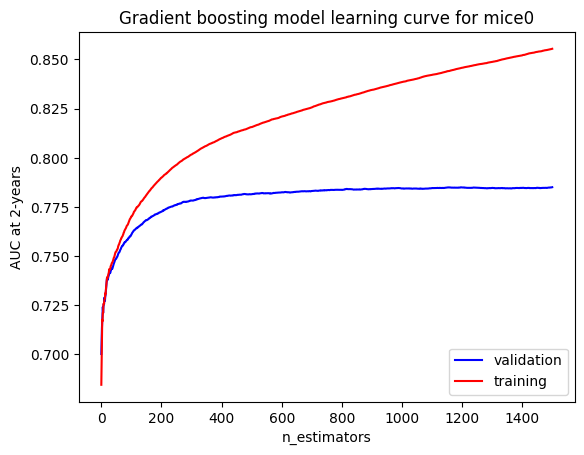

In [133]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm0_staged_auc))
plt.plot(x, gbm0_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm0_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Gradient boosting model learning curve for mice0')

plt.show()

In [134]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm0_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm0_staged_auc[x:x+24]))

In [135]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm0_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm0_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 525
Validation dataset AUC before degrading: 0.781799931284268
Training dataset AUC before degrading: 0.817041674494803


In [136]:
pipe = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 525,
                                                                        learning_rate = 0.05,
                                                                        random_state = 10))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 10)

# Parameter gird 
param_grid = {'estimator__gradientboostingsurvivalanalysis__max_depth': [2, 3, 4], 
              'estimator__gradientboostingsurvivalanalysis__subsample': [0.5, 0.75, 0.9]}

gbm_search = HalvingGridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid,
    cv = cv,
    factor = 2,
    resource = 'n_samples',
    refit = False,
    verbose = 1,
    random_state = 10,
    n_jobs = -1)

# Run search 
warnings.filterwarnings('ignore')
gbm_search.fit(train_mice0_x, train_y)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1892
max_resources_: 15141
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 1892
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 5
n_resources: 3784
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 3
n_resources: 7568
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 15136
Fitting 3 folds for each of 2 candidates, totalling 6 fits


HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=10, shuffle=True),
                    estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                            transformers=[('num',
                                                                                                                           Pipeline(steps=[('std_scaler',
                                                                                                                                            StandardScaler())]),
                                                                                                                           ['age',
                                                                                                 

In [137]:
gbm_search.best_params_

{'estimator__gradientboostingsurvivalanalysis__max_depth': 4,
 'estimator__gradientboostingsurvivalanalysis__subsample': 0.5}

**The above best tree depth and subsample will be used for all models moving forward mainly due to the computational cost of searching for these parameters for each MICE training set. It also seems likely that these two hyperparamters have small impact on test set AUC performance and are unlikely to change by much for each training set.** 

#### Building model and assessing performance 

In [138]:
gbm_mice0 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 525,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 4,
                                                                             subsample = 0.5,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice0.fit(train_mice0_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       31614.4464          25.0227           24.78m
         2       31131.7763          24.1827           24.94m
         3       31427.8186          22.5566           24.90m
         4       31360.1864          21.6726           24.87m
         5       31508.3530          20.8798           24.82m
         6       30867.7123          20.8983           24.78m
         7       31326.8521          19.6506           24.73m
         8       31548.6147          18.7100           24.69m
         9       31374.7476          17.6553           24.65m
        10       31156.9101          17.2468           24.59m
        20       31101.1094          14.3569           24.13m
        30       31081.8102          10.4138           23.68m
        40       30835.8276           6.4332           23.20m
        50       30403.9688           6.0130           22.68m
        60       30920.4393           5.7448           22.17m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'PSADiagnosis',
                                                   'PSAMetDiagnosis',
                                                   'delta_met_diagnosis',
                                                   'crpc_time', 'weight_diag',
                                                   'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                       

In [139]:
dump(gbm_mice0, 'gbm_mice0.joblib') 

['gbm_mice0.joblib']

In [140]:
gbm_risk_scores_te = gbm_mice0.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.7755432722316826


In [141]:
gbm_risk_scores_tr = gbm_mice0.predict(train_mice0_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8335139314378777


In [142]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [143]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.004089520111859086


In [144]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [145]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.004023124352831371


In [146]:
mice_auc_data = {'mice_dataset': ['mice_0'],
                 'auc_2yr_te': [gbm_auc_te],
                 'sem_te': [standard_error_te],
                 'auc_2yr_tr': [gbm_auc_tr],
                 'sem_tr': [standard_error_tr]}

mice_auc_df = pd.DataFrame(mice_auc_data)

In [147]:
mice_auc_df

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.775543,0.00409,0.833514,0.004023


In [148]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [149]:
times = np.arange(30, 1810, 30)
mice0_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice0_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice_auc_over5 = pd.DataFrame(times_data, index = ['mice_0'])

In [150]:
mice_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.927864,0.867938,0.844127,0.840129,0.849537,0.840189,0.822436,0.829647,0.823961,0.820499,...,0.765596,0.764703,0.764506,0.766187,0.766906,0.766149,0.768768,0.768122,0.772134,0.76871


In [151]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [152]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice0_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 184
Number of non-zero features in final model: 175


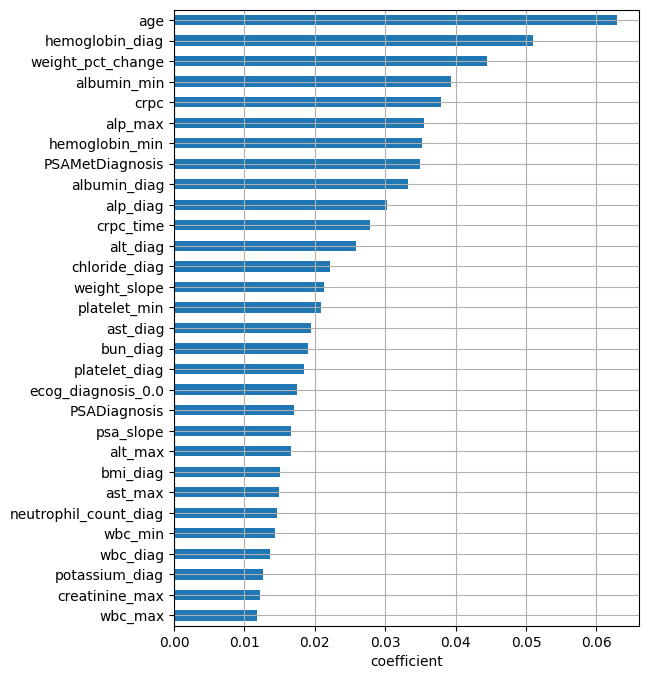

In [153]:
# Dataframe of coefficients for each variable 
coefficients_mice0 = pd.DataFrame(
    gbm_mice0.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice0.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice0.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [154]:
coefficients_mice = (
    coefficients_mice0
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [155]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.2 Model 1

#### Preprocessing and building pipeline 

In [156]:
# Import second training set
train_mice1 = pd.read_csv('mice_tr1.csv', index_col = 'PatientID')

In [157]:
print(train_mice1.shape)

(15141, 197)


In [158]:
train_mice1.isna().sum().sum()

0

In [159]:
train_mice1 = train_mice1.drop(columns = mice_drop)

In [160]:
train_mice1 = train_mice1.drop(columns = dem_var)

In [161]:
print(train_mice1.shape)
print(test_mice.shape)

(15141, 145)
(18930, 147)


In [162]:
train_mice1['ecog_na'] = np.where(train_mice1.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice1['stage_na'] = np.where(train_mice1.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

In [163]:
for x in list(to_be_categorical):
    train_mice1[x] = train_mice1[x].astype('category')
    
list(train_mice1.select_dtypes(include = ['category']).columns)

['Gender',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'stage',
 'met_year',
 'brca_status',
 'ecog_diagnosis',
 'prim_treatment']

In [164]:
train_mice1['death_status'] = train_mice1['death_status'].astype('bool')

In [165]:
val_mice1 = train_mice1[train_mice1.index.isin(val_IDs['PatientID'])]

sub_train_mice1 = train_mice1[~train_mice1.index.isin(val_IDs['PatientID'])]

In [166]:
print(train_mice1.shape)
print(sub_train_mice1.shape)
print(val_mice1.shape)

(15141, 147)
(11355, 147)
(3786, 147)


In [167]:
train_mice1_x = train_mice1.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice1_x = sub_train_mice1.drop(columns = ['death_status', 'timerisk_activity'])

val_mice1_x = val_mice1.drop(columns = ['death_status', 'timerisk_activity'])

In [168]:
print(train_mice1_x.shape)
print(sub_train_mice1_x.shape)
print(val_mice1_x.shape)

(15141, 145)
(11355, 145)
(3786, 145)


#### Hyperparameter tuning 

In [169]:
sub_train_mice1_xt = preprocessor_red.fit_transform(sub_train_mice1_x)
val_mice1_xt = preprocessor_red.transform(val_mice1_x)

gbm_mice1_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 4,
                                                 subsample = 0.5,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice1_exp.fit(sub_train_mice1_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       22802.2641          17.6026           39.61m
         2       23016.9453          16.7207           39.78m
         3       23191.9469          15.9515           39.74m
         4       22605.4262          15.6333           39.73m
         5       23148.7874          15.7983           39.70m
         6       22849.8066          14.9416           39.69m
         7       22876.9503          12.3030           39.65m
         8       22632.7689          13.0383           39.61m
         9       22265.2600          13.8700           39.58m
        10       23015.7089          13.1363           39.57m
        20       22203.7929           9.5733           39.29m
        30       22638.1533           7.6370           39.00m
        40       21984.4278           5.8902           38.72m
        50       21965.3243           4.1196           38.45m
        60       21984.6265           3.5166           38.18m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, max_depth=4,
                                 n_estimators=1500, random_state=42,
                                 subsample=0.5, verbose=1)

In [170]:
gbm1_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice1_exp.staged_predict(val_mice1_xt)]

In [171]:
gbm1_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice1_exp.staged_predict(sub_train_mice1_xt)]

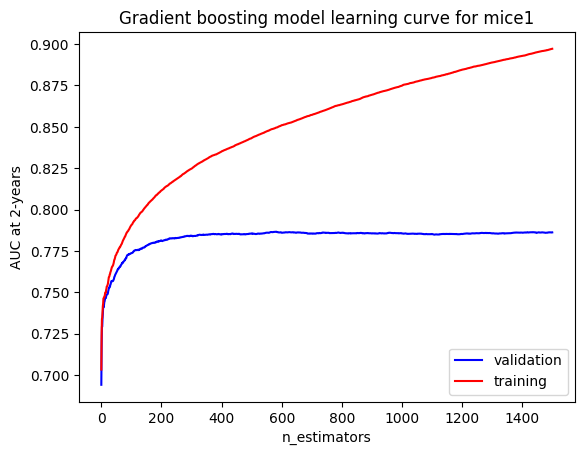

In [172]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm1_staged_auc))
plt.plot(x, gbm1_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm1_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Gradient boosting model learning curve for mice1')

plt.show()

In [173]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm1_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm1_staged_auc[x:x+24]))

In [174]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm1_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm1_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 425
Validation dataset AUC before degrading: 0.7851794959145686
Training dataset AUC before degrading: 0.8370164324881897


#### Building model and assessing performance 

In [175]:
gbm_mice1 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 4,
                                                                             subsample = 0.5,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice1.fit(train_mice1_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       31614.7643          23.6646           20.19m
         2       31132.7313          24.4220           20.24m
         3       31429.0291          22.3871           20.21m
         4       31361.4854          21.9293           20.19m
         5       31510.8337          21.0204           20.15m
         6       30868.4062          20.7834           20.10m
         7       31327.1347          19.5740           20.06m
         8       31547.9111          19.1235           20.01m
         9       31374.0085          17.8974           19.97m
        10       31153.4894          17.7492           19.91m
        20       31109.9626          13.7532           19.44m
        30       31095.6221           9.7220           18.96m
        40       30846.8510           8.3683           18.48m
        50       30414.7904           6.3946           18.00m
        60       30930.9433           4.1339           17.52m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'PSADiagnosis',
                                                   'PSAMetDiagnosis',
                                                   'delta_met_diagnosis',
                                                   'crpc_time', 'weight_diag',
                                                   'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                       

In [176]:
dump(gbm_mice1, 'gbm_mice1.joblib') 

['gbm_mice1.joblib']

In [177]:
gbm_risk_scores_te = gbm_mice1.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.7717620304601127


In [178]:
gbm_risk_scores_tr = gbm_mice1.predict(train_mice1_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8284809212037821


In [179]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [180]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.0041265463876872365


In [181]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [182]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.003987302018609324


In [183]:
mice_auc_data = {'mice_dataset': 'mice_1',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [184]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.775543,0.004090,0.833514,0.004023
1,mice_1,0.771762,0.004127,0.828481,0.003987


In [185]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [186]:
times = np.arange(30, 1810, 30)
mice1_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice1_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice1_auc_over5_df = pd.DataFrame(times_data, index = ['mice_1'])

mice_auc_over5 = mice_auc_over5.append(mice1_auc_over5_df, ignore_index = False)

In [187]:
mice_auc_over5 

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.927864,0.867938,0.844127,0.840129,0.849537,0.840189,0.822436,0.829647,0.823961,0.820499,...,0.765596,0.764703,0.764506,0.766187,0.766906,0.766149,0.768768,0.768122,0.772134,0.768710
mice_1,0.936911,0.862256,0.841794,0.841586,0.848369,0.837816,0.821175,0.828226,0.821135,0.818188,...,0.765077,0.763884,0.763574,0.765922,0.766976,0.766039,0.769752,0.769359,0.774085,0.770352


In [188]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [189]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice1_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 184
Number of non-zero features in final model: 172


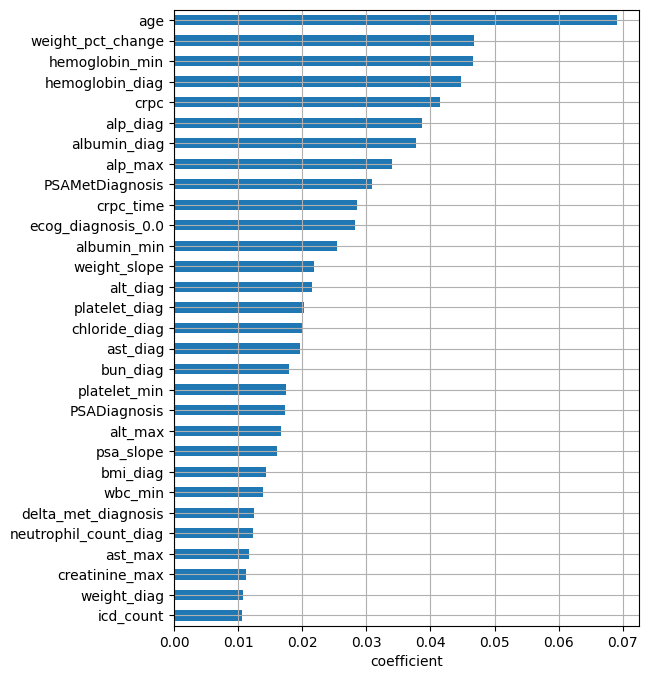

In [190]:
# Dataframe of coefficients for each variable 
coefficients_mice1 = pd.DataFrame(
    gbm_mice1.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice1.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice1.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [191]:
coefficients_mice1_df = (
    coefficients_mice1
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [192]:
coefficients_mice = coefficients_mice.append(coefficients_mice1_df, ignore_index = True)

In [193]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.3 Model 3

#### Preprocessing 

In [194]:
train_mice2 = pd.read_csv('mice_tr2.csv', index_col = 'PatientID')

In [195]:
print(train_mice2.shape)

(15141, 197)


In [196]:
train_mice2.isna().sum().sum()

0

In [197]:
train_mice2 = train_mice2.drop(columns = mice_drop)

In [198]:
train_mice2 = train_mice2.drop(columns = dem_var)

In [199]:
print(train_mice2.shape)

(15141, 145)


In [200]:
train_mice2['ecog_na'] = np.where(train_mice2.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice2['stage_na'] = np.where(train_mice2.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

In [201]:
for x in list(to_be_categorical):
    train_mice2[x] = train_mice2[x].astype('category')
    
list(train_mice2.select_dtypes(include = ['category']).columns)

['Gender',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'stage',
 'met_year',
 'brca_status',
 'ecog_diagnosis',
 'prim_treatment']

In [202]:
train_mice2['death_status'] = train_mice2['death_status'].astype('bool')

In [203]:
val_mice2 = train_mice2[train_mice2.index.isin(val_IDs['PatientID'])]

sub_train_mice2 = train_mice2[~train_mice2.index.isin(val_IDs['PatientID'])]

In [204]:
print(train_mice2.shape)
print(sub_train_mice2.shape)
print(val_mice2.shape)

(15141, 147)
(11355, 147)
(3786, 147)


In [205]:
train_mice2_x = train_mice2.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice2_x = sub_train_mice2.drop(columns = ['death_status', 'timerisk_activity'])

val_mice2_x = val_mice2.drop(columns = ['death_status', 'timerisk_activity'])

In [206]:
print(train_mice2_x.shape)
print(sub_train_mice2_x.shape)
print(val_mice2_x.shape)

(15141, 145)
(11355, 145)
(3786, 145)


#### Hyperparameter tuning 

In [207]:
sub_train_mice2_xt = preprocessor_red.fit_transform(sub_train_mice2_x)
val_mice2_xt = preprocessor_red.transform(val_mice2_x)

gbm_mice2_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 4,
                                                 subsample = 0.5,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice2_exp.fit(sub_train_mice2_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       22803.5106          16.8759           39.61m
         2       23017.3392          16.9224           39.70m
         3       23192.0848          16.6656           39.68m
         4       22603.5641          15.1510           39.72m
         5       23149.2614          15.2888           39.73m
         6       22850.0236          14.7846           39.67m
         7       22877.5635          14.7009           39.64m
         8       22634.0189          13.4316           39.63m
         9       22264.4718          14.0868           39.60m
        10       23014.2981          12.0991           39.56m
        20       22208.5488           9.2170           39.29m
        30       22641.6715           6.6383           38.99m
        40       21998.2814           6.2068           38.71m
        50       21975.7196           4.5330           38.43m
        60       21987.5746           3.4560           38.15m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, max_depth=4,
                                 n_estimators=1500, random_state=42,
                                 subsample=0.5, verbose=1)

In [208]:
gbm2_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice2_exp.staged_predict(val_mice2_xt)]

In [209]:
gbm2_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice2_exp.staged_predict(sub_train_mice2_xt)]

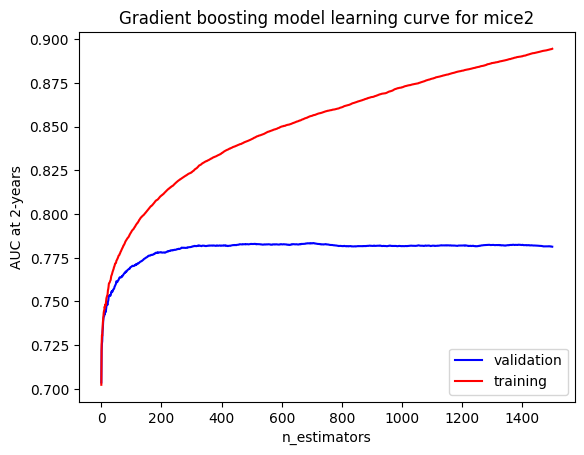

In [210]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm2_staged_auc))
plt.plot(x, gbm2_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm2_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Gradient boosting model learning curve for mice2')

plt.show()

In [211]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm2_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm2_staged_auc[x:x+24]))

In [212]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm2_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm2_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 350
Validation dataset AUC before degrading: 0.7817471086150164
Training dataset AUC before degrading: 0.8303562876048203


#### Building model and assessing performance 

In [213]:
gbm_mice2 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 4,
                                                                             subsample = 0.5,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice2.fit(train_mice2_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       31614.2108          23.5547           16.65m
         2       31131.5155          24.2268           16.66m
         3       31429.2643          23.1570           16.63m
         4       31359.0216          22.0965           16.59m
         5       31509.8164          21.8635           16.54m
         6       30865.4607          20.3472           16.50m
         7       31322.9437          20.2228           16.45m
         8       31547.2155          18.1487           16.40m
         9       31375.6064          18.1944           16.35m
        10       31156.3175          17.9668           16.31m
        20       31104.7662          13.1950           15.84m
        30       31086.5966           9.4109           15.36m
        40       30845.7557           8.1227           14.88m
        50       30405.0033           7.0006           14.40m
        60       30925.2369           3.9650           13.92m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'PSADiagnosis',
                                                   'PSAMetDiagnosis',
                                                   'delta_met_diagnosis',
                                                   'crpc_time', 'weight_diag',
                                                   'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                       

In [214]:
dump(gbm_mice2, 'gbm_mice2.joblib') 

['gbm_mice2.joblib']

In [215]:
gbm_risk_scores_te = gbm_mice2.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 year:', gbm_auc_te)

Test set AUC at 2 year: 0.7728401364392564


In [216]:
gbm_risk_scores_tr = gbm_mice2.predict(train_mice2_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 year:', gbm_auc_tr)

Training set AUC at 2 year: 0.8213387359871551


In [217]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [218]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.004084453641700399


In [219]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [220]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.004185480374597161


In [221]:
mice_auc_data = {'mice_dataset': 'mice_2',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [222]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.775543,0.004090,0.833514,0.004023
1,mice_1,0.771762,0.004127,0.828481,0.003987
2,mice_2,0.772840,0.004084,0.821339,0.004185


In [223]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [224]:
times = np.arange(30, 1810, 30)
mice2_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice2_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice2_auc_over5_df = pd.DataFrame(times_data, index = ['mice_2'])

mice_auc_over5 = mice_auc_over5.append(mice2_auc_over5_df, ignore_index = False)

In [225]:
mice_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.927864,0.867938,0.844127,0.840129,0.849537,0.840189,0.822436,0.829647,0.823961,0.820499,...,0.765596,0.764703,0.764506,0.766187,0.766906,0.766149,0.768768,0.768122,0.772134,0.768710
mice_1,0.936911,0.862256,0.841794,0.841586,0.848369,0.837816,0.821175,0.828226,0.821135,0.818188,...,0.765077,0.763884,0.763574,0.765922,0.766976,0.766039,0.769752,0.769359,0.774085,0.770352
mice_2,0.932352,0.858939,0.842798,0.839143,0.846344,0.837919,0.820410,0.828029,0.821133,0.817434,...,0.764765,0.763423,0.762947,0.765148,0.765898,0.765618,0.769512,0.768575,0.772191,0.768910


In [226]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [227]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice2_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 184
Number of non-zero features in final model: 167


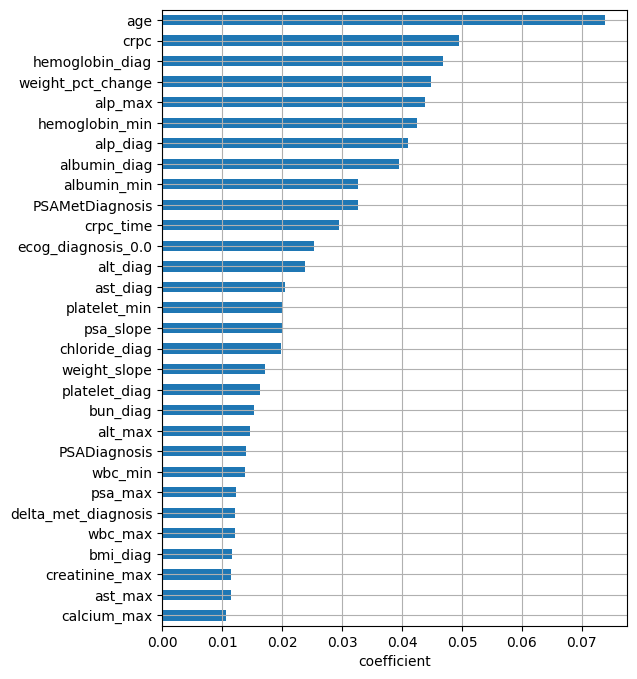

In [228]:
# Dataframe of coefficients for each variable 
coefficients_mice2 = pd.DataFrame(
    gbm_mice2.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice2.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice2.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [229]:
coefficients_mice2_df = (
    coefficients_mice2
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [230]:
coefficients_mice = coefficients_mice.append(coefficients_mice2_df, ignore_index = True)

In [231]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.4 Model 4

#### Preprocessing 

In [232]:
train_mice3 = pd.read_csv('mice_tr3.csv', index_col = 'PatientID')

In [233]:
print(train_mice3.shape)

(15141, 197)


In [234]:
train_mice3.isna().sum().sum()

0

In [235]:
train_mice3 = train_mice3.drop(columns = mice_drop)

In [236]:
train_mice3 = train_mice3.drop(columns = dem_var)

In [237]:
print(train_mice3.shape)

(15141, 145)


In [238]:
train_mice3['ecog_na'] = np.where(train_mice3.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice3['stage_na'] = np.where(train_mice3.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

In [239]:
for x in list(to_be_categorical):
    train_mice3[x] = train_mice3[x].astype('category')
    
list(train_mice3.select_dtypes(include = ['category']).columns)

['Gender',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'stage',
 'met_year',
 'brca_status',
 'ecog_diagnosis',
 'prim_treatment']

In [240]:
train_mice3['death_status'] = train_mice3['death_status'].astype('bool')

In [241]:
val_mice3 = train_mice3[train_mice3.index.isin(val_IDs['PatientID'])]

sub_train_mice3 = train_mice3[~train_mice3.index.isin(val_IDs['PatientID'])]

In [242]:
print(train_mice3.shape)
print(sub_train_mice3.shape)
print(val_mice3.shape)

(15141, 147)
(11355, 147)
(3786, 147)


In [243]:
train_mice3_x = train_mice3.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice3_x = sub_train_mice3.drop(columns = ['death_status', 'timerisk_activity'])

val_mice3_x = val_mice3.drop(columns = ['death_status', 'timerisk_activity'])

In [244]:
print(train_mice3_x.shape)
print(sub_train_mice3_x.shape)
print(val_mice3_x.shape)

(15141, 145)
(11355, 145)
(3786, 145)


#### Hyperparameter tuning 

In [245]:
sub_train_mice3_xt = preprocessor_red.fit_transform(sub_train_mice3_x)
val_mice3_xt = preprocessor_red.transform(val_mice3_x)

gbm_mice3_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 4,
                                                 subsample = 0.5,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice3_exp.fit(sub_train_mice3_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       22801.8089          18.2878           40.00m
         2       23016.1847          15.9482           40.10m
         3       23191.2112          17.0698           40.08m
         4       22602.2008          15.8179           40.06m
         5       23148.8472          15.0900           40.05m
         6       22846.5354          13.9608           40.02m
         7       22874.9889          14.3407           39.98m
         8       22636.4278          13.5005           39.95m
         9       22264.3302          13.9737           39.93m
        10       23017.2270          13.1384           39.90m
        20       22204.6016           8.9298           39.61m
        30       22632.5582           7.3228           39.30m
        40       21991.2837           4.7791           39.00m
        50       21984.5993           4.1860           38.70m
        60       21985.4202           3.3386           38.41m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, max_depth=4,
                                 n_estimators=1500, random_state=42,
                                 subsample=0.5, verbose=1)

In [246]:
gbm3_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice3_exp.staged_predict(val_mice3_xt)]

In [247]:
gbm3_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice3_exp.staged_predict(sub_train_mice3_xt)]

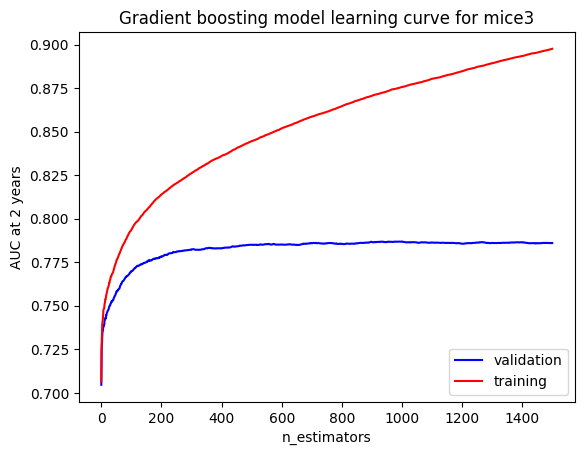

In [248]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm3_staged_auc))
plt.plot(x, gbm3_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm3_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2 years")
plt.title('Gradient boosting model learning curve for mice3')

plt.show()

In [249]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm3_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm3_staged_auc[x:x+24]))

In [250]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm3_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm3_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 350
Validation dataset AUC before degrading: 0.7829077679318687
Training dataset AUC before degrading: 0.8314272590843659


#### Model building and performance assessment 

In [251]:
gbm_mice3 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 4,
                                                                             subsample = 0.5,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice3.fit(train_mice3_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       31614.4845          24.3232           16.82m
         2       31131.5769          24.6192           16.83m
         3       31426.9538          22.8694           16.79m
         4       31359.5003          22.3834           16.76m
         5       31508.8366          21.5775           16.71m
         6       30864.2504          20.8028           16.67m
         7       31323.2868          18.3841           16.62m
         8       31545.1322          18.3560           16.57m
         9       31371.7735          17.7545           16.53m
        10       31152.3802          16.8528           16.48m
        20       31107.7714          13.3124           16.00m
        30       31081.4521           8.7531           15.52m
        40       30848.5931           7.7436           15.03m
        50       30401.0016           5.7326           14.54m
        60       30923.2690           4.1162           14.05m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'PSADiagnosis',
                                                   'PSAMetDiagnosis',
                                                   'delta_met_diagnosis',
                                                   'crpc_time', 'weight_diag',
                                                   'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                       

In [252]:
dump(gbm_mice3, 'gbm_mice3.joblib') 

['gbm_mice3.joblib']

In [253]:
gbm_risk_scores_te = gbm_mice3.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.7710000799926662


In [254]:
gbm_risk_scores_tr = gbm_mice3.predict(train_mice3_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8221915159767419


In [255]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [256]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.0041125957806519885


In [257]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [258]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.004166348057126182


In [259]:
mice_auc_data = {'mice_dataset': 'mice_3',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [260]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.775543,0.004090,0.833514,0.004023
1,mice_1,0.771762,0.004127,0.828481,0.003987
2,mice_2,0.772840,0.004084,0.821339,0.004185
3,mice_3,0.771000,0.004113,0.822192,0.004166


In [261]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [262]:
times = np.arange(30, 1810, 30)
mice3_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice3_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice3_auc_over5_df = pd.DataFrame(times_data, index = ['mice_3'])

mice_auc_over5 = mice_auc_over5.append(mice3_auc_over5_df, ignore_index = False)

In [263]:
mice_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.927864,0.867938,0.844127,0.840129,0.849537,0.840189,0.822436,0.829647,0.823961,0.820499,...,0.765596,0.764703,0.764506,0.766187,0.766906,0.766149,0.768768,0.768122,0.772134,0.768710
mice_1,0.936911,0.862256,0.841794,0.841586,0.848369,0.837816,0.821175,0.828226,0.821135,0.818188,...,0.765077,0.763884,0.763574,0.765922,0.766976,0.766039,0.769752,0.769359,0.774085,0.770352
mice_2,0.932352,0.858939,0.842798,0.839143,0.846344,0.837919,0.820410,0.828029,0.821133,0.817434,...,0.764765,0.763423,0.762947,0.765148,0.765898,0.765618,0.769512,0.768575,0.772191,0.768910
mice_3,0.897310,0.851153,0.836009,0.831478,0.842538,0.835452,0.818576,0.825443,0.817052,0.813570,...,0.762546,0.760807,0.760640,0.762762,0.763316,0.762189,0.765789,0.765673,0.770010,0.766991


In [264]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [265]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice3_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 184
Number of non-zero features in final model: 167


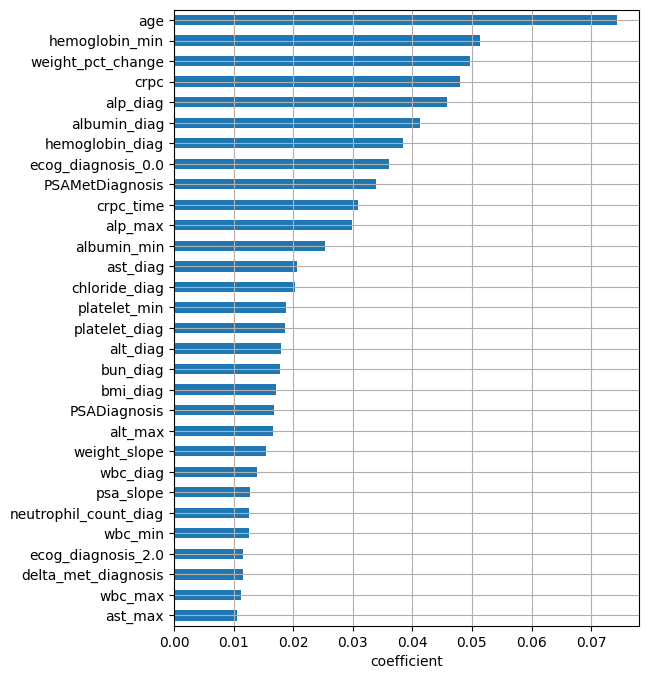

In [266]:
# Dataframe of coefficients for each variable 
coefficients_mice3 = pd.DataFrame(
    gbm_mice3.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice3.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice3.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [267]:
coefficients_mice3_df = (
    coefficients_mice3
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [268]:
coefficients_mice = coefficients_mice.append(coefficients_mice3_df, ignore_index = True)

In [269]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.5 Model 5

#### Preprocessing

In [270]:
train_mice4 = pd.read_csv('mice_tr4.csv', index_col = 'PatientID')

In [271]:
train_mice4.shape

(15141, 197)

In [272]:
train_mice4.isna().sum().sum()

0

In [273]:
train_mice4 = train_mice4.drop(columns = mice_drop)

In [274]:
train_mice4 = train_mice4.drop(columns = dem_var)

In [275]:
print(train_mice4.shape)

(15141, 145)


In [276]:
train_mice4['ecog_na'] = np.where(train_mice4.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice4['stage_na'] = np.where(train_mice4.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

In [277]:
for x in list(to_be_categorical):
    train_mice4[x] = train_mice4[x].astype('category')
    
list(train_mice4.select_dtypes(include = ['category']).columns)

['Gender',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'stage',
 'met_year',
 'brca_status',
 'ecog_diagnosis',
 'prim_treatment']

In [278]:
train_mice4['death_status'] = train_mice4['death_status'].astype('bool')

In [279]:
val_mice4 = train_mice4[train_mice4.index.isin(val_IDs['PatientID'])]

sub_train_mice4 = train_mice4[~train_mice4.index.isin(val_IDs['PatientID'])]

In [280]:
print(train_mice4.shape)
print(sub_train_mice4.shape)
print(val_mice4.shape)

(15141, 147)
(11355, 147)
(3786, 147)


In [281]:
train_mice4_x = train_mice4.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice4_x = sub_train_mice4.drop(columns = ['death_status', 'timerisk_activity'])

val_mice4_x = val_mice4.drop(columns = ['death_status', 'timerisk_activity'])

In [282]:
print(train_mice4_x.shape)
print(sub_train_mice4_x.shape)
print(val_mice4_x.shape)

(15141, 145)
(11355, 145)
(3786, 145)


#### Hyperparameter tuning

In [283]:
sub_train_mice4_xt = preprocessor_red.fit_transform(sub_train_mice4_x)
val_mice4_xt = preprocessor_red.transform(val_mice4_x)

gbm_mice4_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 4,
                                                 subsample = 0.5,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice4_exp.fit(sub_train_mice4_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       22801.3186          17.6669           40.06m
         2       23016.6647          17.6682           40.10m
         3       23191.2006          17.1773           40.13m
         4       22602.4162          15.9643           40.10m
         5       23147.7327          15.4392           40.08m
         6       22848.7420          14.2158           40.06m
         7       22876.1915          13.8375           40.05m
         8       22634.9197          12.9790           40.02m
         9       22265.6213          13.5561           40.01m
        10       23016.9357          13.2625           39.98m
        20       22205.1247           8.1266           39.71m
        30       22638.3474           7.4806           39.42m
        40       21994.0714           5.7226           39.16m
        50       21963.9891           4.7778           38.88m
        60       21996.9175           4.2005           38.61m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, max_depth=4,
                                 n_estimators=1500, random_state=42,
                                 subsample=0.5, verbose=1)

In [284]:
gbm4_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice4_exp.staged_predict(val_mice4_xt)]

In [285]:
gbm4_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice4_exp.staged_predict(sub_train_mice4_xt)]

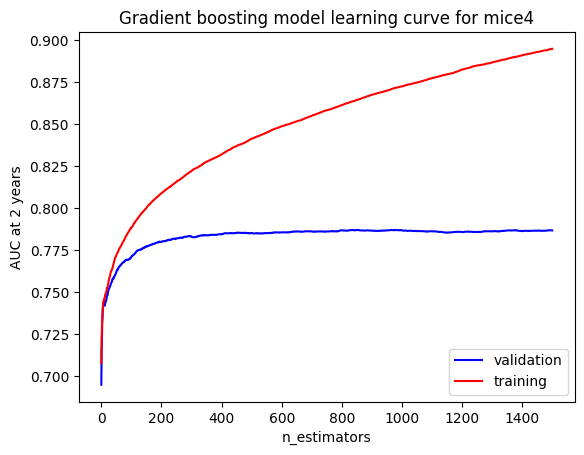

In [286]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm4_staged_auc))
plt.plot(x, gbm4_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm4_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2 years")
plt.title('Gradient boosting model learning curve for mice4')

plt.show()

In [287]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm4_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm4_staged_auc[x:x+24]))

In [288]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm4_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm4_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 275
Validation dataset AUC before degrading: 0.7826567260669223
Training dataset AUC before degrading: 0.8186585452088175


#### Model building and performance assessment 

In [289]:
print(train_mice4_x.shape)
print(train_y.shape)

(15141, 145)
(15141,)


In [290]:
gbm_mice4 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 4,
                                                                             subsample = 0.5,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice4.fit(train_mice4_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       31613.6653          24.8556           13.26m
         2       31132.3130          23.6243           13.23m
         3       31428.5377          22.9438           13.20m
         4       31359.8110          21.2859           13.15m
         5       31509.9380          21.8704           13.10m
         6       30866.2758          21.1722           13.06m
         7       31324.4850          20.3280           13.00m
         8       31542.5541          18.3923           12.95m
         9       31371.0231          17.7583           12.91m
        10       31152.4854          17.8540           12.86m
        20       31099.4768          12.7851           12.37m
        30       31083.4686          10.0126           11.89m
        40       30844.5826           7.1636           11.40m
        50       30414.9820           5.5513           10.92m
        60       30925.5869           4.3519           10.43m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'PSADiagnosis',
                                                   'PSAMetDiagnosis',
                                                   'delta_met_diagnosis',
                                                   'crpc_time', 'weight_diag',
                                                   'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                       

In [291]:
dump(gbm_mice4, 'gbm_mice4.joblib') 

['gbm_mice4.joblib']

In [292]:
gbm_risk_scores_te = gbm_mice4.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.7710465794162505


In [293]:
gbm_risk_scores_tr = gbm_mice4.predict(train_mice4_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8111508045130942


In [294]:
# Bootstrap 10000 2 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [295]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.004089227001752379


In [296]:
# Bootstrap 10000 2 yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [297]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.004268866587656553


In [298]:
mice_auc_data = {'mice_dataset': 'mice_4',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [299]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.775543,0.004090,0.833514,0.004023
1,mice_1,0.771762,0.004127,0.828481,0.003987
2,mice_2,0.772840,0.004084,0.821339,0.004185
3,mice_3,0.771000,0.004113,0.822192,0.004166
4,mice_4,0.771047,0.004089,0.811151,0.004269


In [300]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [301]:
times = np.arange(30, 1810, 30)
mice4_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice4_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice4_auc_over5_df = pd.DataFrame(times_data, index = ['mice_4'])

mice_auc_over5 = mice_auc_over5.append(mice4_auc_over5_df, ignore_index = False)

In [302]:
mice_auc_over5 

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.927864,0.867938,0.844127,0.840129,0.849537,0.840189,0.822436,0.829647,0.823961,0.820499,...,0.765596,0.764703,0.764506,0.766187,0.766906,0.766149,0.768768,0.768122,0.772134,0.768710
mice_1,0.936911,0.862256,0.841794,0.841586,0.848369,0.837816,0.821175,0.828226,0.821135,0.818188,...,0.765077,0.763884,0.763574,0.765922,0.766976,0.766039,0.769752,0.769359,0.774085,0.770352
mice_2,0.932352,0.858939,0.842798,0.839143,0.846344,0.837919,0.820410,0.828029,0.821133,0.817434,...,0.764765,0.763423,0.762947,0.765148,0.765898,0.765618,0.769512,0.768575,0.772191,0.768910
mice_3,0.897310,0.851153,0.836009,0.831478,0.842538,0.835452,0.818576,0.825443,0.817052,0.813570,...,0.762546,0.760807,0.760640,0.762762,0.763316,0.762189,0.765789,0.765673,0.770010,0.766991
mice_4,0.928432,0.852166,0.836108,0.835533,0.844463,0.834575,0.816203,0.823212,0.816104,0.813040,...,0.765507,0.763649,0.761908,0.763911,0.764918,0.763829,0.767942,0.767632,0.771444,0.768395


In [303]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [304]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice4_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 184
Number of non-zero features in final model: 157


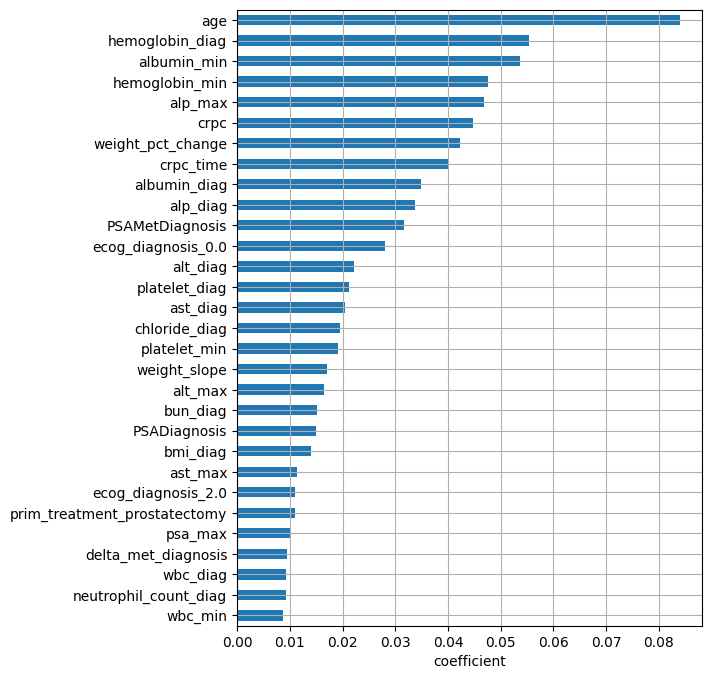

In [305]:
# Dataframe of coefficients for each variable 
coefficients_mice4 = pd.DataFrame(
    gbm_mice4.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice4.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice4.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [306]:
coefficients_mice4_df = (
    coefficients_mice4
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [307]:
coefficients_mice = coefficients_mice.append(coefficients_mice4_df, ignore_index = True)

In [308]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### Part 4. Pooling results

#### 4.1 Pooling AUC

In [309]:
from math import sqrt, exp 
from scipy.stats import t

**Test and training AUCs will be pooled using Rubin’s rules. This is complicated by the fact that AUCs are bounded and thus not normally distributed. The AUCs will therefore be logit transformed to an unbounded scale, then Rubin's rules will be applied to these values, and finally they will be back-transformed into a final pool estimate.** 

In [310]:
# This function is translated from the R package: "psfmi: Prediction Model Selection and Performance Evaluation in
# Multiple Imputed Datasets"

def pool_auc(auc_arr, se_arr, iterations_n):
    
    # pooled SE using Rubin's rules 
    def rr_se(est, se, iterations_n):
        m = iterations_n
        w_auc = np.mean(np.square(se)) # within variance 
        b_auc = np.var(est) # between variance 
        tv_auc = w_auc + (1 + (1/m)) * b_auc # total vairance 
        se_total = sqrt(tv_auc)
        r = (1 + (1/ m)) * (b_auc / w_auc)
        v = (m - 1) * (1 + (1/r))**2
        w = t.ppf(0.975, v) # Percent point function or inverse CDF with df = v
        res = np.array([se_total, w])
        return(res)
    
    # log transform
    auc_log = np.log(auc_arr / (1-auc_arr))
    se_log = se_arr / (auc_arr * (1-auc_arr))
    
    # input log transfomred auc and se to calculat RR's total se
    se_total = rr_se(auc_log, se_log, iterations_n = iterations_n)
    
    # backtransform 
    inv_auc = exp(np.mean(auc_log)) / (1 + exp(np.mean(auc_log)))
    inv_auc_upper = exp(np.mean(auc_log) + (se_total[1]*se_total[0])) / (1 + exp(np.mean(auc_log) + (se_total[1]*se_total[0])))
    inv_auc_lower = exp(np.mean(auc_log) - (se_total[1]*se_total[0])) / (1 + exp(np.mean(auc_log) - (se_total[1]*se_total[0])))
    sem = (inv_auc_upper - inv_auc_lower) / 3.92
    auc_res = np.round(np.array([inv_auc_lower, inv_auc, inv_auc_upper, sem]), 6)
    return(auc_res)

In [311]:
mice_auc_df = pd.read_csv('mice_auc_df.csv', dtype = {'auc_2yr_te': np.float64,
                                                      'sem_te': np.float64,
                                                      'auc_2yr_tr': np.float64,
                                                      'sem_tr': np.float64})

In [312]:
mice_auc_df

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.775543,0.004090,0.833514,0.004023
1,mice_1,0.771762,0.004127,0.828481,0.003987
2,mice_2,0.772840,0.004084,0.821339,0.004185
3,mice_3,0.771000,0.004113,0.822192,0.004166
4,mice_4,0.771047,0.004089,0.811151,0.004269


In [313]:
pool_auc_test = pool_auc(mice_auc_df['auc_2yr_te'].values, 
                         mice_auc_df['sem_te'].values, 
                         5)

print(pool_auc_test)

[0.763421 0.772443 0.781219 0.00454 ]


In [314]:
pool_auc_train = pool_auc(mice_auc_df['auc_2yr_tr'].values,
                          mice_auc_df['sem_tr'].values,
                          5)

print(pool_auc_train)

[0.80008  0.82346  0.844638 0.011367]


In [315]:
crude_auc_df = pd.read_csv('crude_auc_df.csv', dtype = {'auc_2yr_te': np.float64,
                                                        'sem_te': np.float64,
                                                        'auc_2yr_tr': np.float64,
                                                        'sem_tr': np.float64})

In [316]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.754326,0.009489,0.784849,0.004590
1,rsf_crude,0.747107,0.009631,0.835588,0.003914
2,ridge_crude,0.739499,0.009629,0.743281,0.004897
3,lasso_crude,0.729512,0.009712,0.733718,0.004997
4,enet_crude,0.731323,0.009719,0.734977,0.004973
5,linear_svm_crude,0.740643,0.009662,0.746230,0.004833


In [317]:
mice_auc_data = {'model': 'gbm_mice',
                 'auc_2yr_te': pool_auc_test[1],
                 'sem_te': pool_auc_test[3],
                 'auc_2yr_tr': pool_auc_train[1],
                 'sem_tr': pool_auc_train[3]}

In [318]:
ml_auc_df = crude_auc_df.append(mice_auc_data, ignore_index = True)

In [319]:
ml_auc_df.sort_values(by = 'auc_2yr_te', ascending = False)

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
6,gbm_mice,0.772443,0.004540,0.823460,0.011367
0,gbm_crude,0.754326,0.009489,0.784849,0.004590
1,rsf_crude,0.747107,0.009631,0.835588,0.003914
5,linear_svm_crude,0.740643,0.009662,0.746230,0.004833
2,ridge_crude,0.739499,0.009629,0.743281,0.004897
4,enet_crude,0.731323,0.009719,0.734977,0.004973
3,lasso_crude,0.729512,0.009712,0.733718,0.004997


In [320]:
ml_auc_df.to_csv('ml_auc_df.csv', index = False, header = True)